<a href="https://colab.research.google.com/github/Alexandre-Data/OC-Projet-7/blob/main/Projet7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!git version

git version 2.25.1


In [5]:
!git config –global user.email "alexandre.romeo@hotmail.fr"

fatal: not in a git directory


In [ ]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

In [ ]:
!git config –global user.name "Alexandre-Data"

In [5]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=5bb11785b3dfe2169349fe97fea41e647d8b49cf1046ad245bf354d1c0f193ff
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok


In [3]:
!pip install mlflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.8 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143860 sha256=853fbf6e83fd1deae2e8aaa15c3b93fad6a72dea7352e11469509c8a2c133843
  Stored in directory: /root/.cache/pip/wheels/a

In [15]:
!pip install SMOTE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mlflow
import smote
from pyngrok import ngrok
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [8]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [10]:
application_train_test()

Train samples: 307511, test samples: 48744


,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,0,0,0,0,0,0.258838,0.294503,121500.0,0.143815,0.042354
356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,0,0,0,0,0,0.102718,0.253047,39375.0,0.202600,0.051267
356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,0,1,0,1,0,0.190742,0.642857,67500.0,0.163978,0.105414
356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,1,0,0,1,0,0.195518,0.500000,112500.0,0.111680,0.055840


In [11]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [12]:
bureau_and_balance()

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.0,0.0,35.000000,140.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.000000,90.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,13.000000,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,-2713,-483,-1667.076923,407302.243590,-2499.0,1363.0,-1232.333333,-1064.538462,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
456250,-1002,-760,-862.000000,15724.000000,-272.0,2340.0,1288.333333,-60.333333,0,0.0,...,0.0,0.0,0.0,384147.0,384147.0,0.0,-32.0,0.0,33.000000,33.0
456253,-919,-713,-867.500000,10609.000000,-189.0,1113.0,280.500000,-253.250000,0,0.0,...,0.0,0.0,0.0,58369.5,58369.5,0.0,-30.0,0.0,31.000000,62.0


In [13]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [14]:
previous_applications()

,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,...,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3951.000,3951.000,3951.000000,24835.5,24835.5,24835.500,23787.0,23787.0,23787.00,1.044079,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,9251.775,9251.775,9251.775000,179055.0,179055.0,179055.000,179055.0,179055.0,179055.00,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,6737.310,98356.995,56553.990000,68809.5,900000.0,435436.500,68053.5,1035882.0,484191.00,0.868825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,5357.250,5357.250,5357.250000,24282.0,24282.0,24282.000,20106.0,20106.0,20106.00,1.207699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,4813.200,4813.200,4813.200000,0.0,44617.5,22308.750,0.0,40153.5,20076.75,1.111173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,6605.910,6605.910,6605.910000,40455.0,40455.0,40455.000,40455.0,40455.0,40455.00,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456252,10074.465,10074.465,10074.465000,57595.5,57595.5,57595.500,56821.5,56821.5,56821.50,1.013622,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456253,3973.095,5567.715,4770.405000,19413.0,28912.5,24162.750,13945.5,27306.0,20625.75,1.058833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [ ]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [ ]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('/content/drive/MyDrive/OPENCLASSROOM/PROJET 7/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [ ]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
# Creating a list of feature names
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    # Clean the feature names
    train_df.columns = train_df.columns.str.replace('[^\w]', '_', regex=True)
    test_df.columns = test_df.columns.str.replace('[^\w]', '_', regex=True)




    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [ ]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [ ]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 22s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 25s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 14s
Installments payments df shape: (339587, 26)
Process installments payments - done in 30s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 19s
Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future rel

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.797104	training's binary_logloss: 0.234829	valid_1's auc: 0.776089	valid_1's binary_logloss: 0.246759
[400]	training's auc: 0.819226	training's binary_logloss: 0.22537	valid_1's auc: 0.787159	valid_1's binary_logloss: 0.242511
[600]	training's auc: 0.834155	training's binary_logloss: 0.219277	valid_1's auc: 0.790742	valid_1's binary_logloss: 0.241208
[800]	training's auc: 0.846219	training's binary_logloss: 0.214311	valid_1's auc: 0.792638	valid_1's binary_logloss: 0.240572
[1000]	training's auc: 0.856646	training's binary_logloss: 0.20991	valid_1's auc: 0.793314	valid_1's binary_logloss: 0.240345
[1200]	training's auc: 0.866329	training's binary_logloss: 0.205763	valid_1's auc: 0.794016	valid_1's binary_logloss: 0.240111
[1400]	training's auc: 0.875268	training's binary_logloss: 0.2017	valid_1's auc: 0.794374	valid_1's binary_logloss: 0.240002


2023/05/24 20:32:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID bfb5e7d409db41168d2383733dbe5ea2. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
2023/05/24 20:32:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based

Fold  1 AUC : 0.794514


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future rel

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.796504	training's binary_logloss: 0.235573	valid_1's auc: 0.777058	valid_1's binary_logloss: 0.241702
[400]	training's auc: 0.819063	training's binary_logloss: 0.226043	valid_1's auc: 0.786754	valid_1's binary_logloss: 0.237454
[600]	training's auc: 0.833962	training's binary_logloss: 0.21997	valid_1's auc: 0.788941	valid_1's binary_logloss: 0.236447
[800]	training's auc: 0.846139	training's binary_logloss: 0.214955	valid_1's auc: 0.790289	valid_1's binary_logloss: 0.235906
[1000]	training's auc: 0.856195	training's binary_logloss: 0.210675	valid_1's auc: 0.790743	valid_1's binary_logloss: 0.235667
[1200]	training's auc: 0.865472	training's binary_logloss: 0.206638	valid_1's auc: 0.79094	valid_1's binary_logloss: 0.23555
[1400]	training's auc: 0.874355	training's binary_logloss: 0.202693	valid_1's auc: 0.791202	valid_1's binary_logloss: 0.235424

2023/05/24 20:36:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID bfb5e7d409db41168d2383733dbe5ea2. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
2023/05/24 20:36:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based

Fold  2 AUC : 0.791501


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future rel

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.797097	training's binary_logloss: 0.235026	valid_1's auc: 0.76787	valid_1's binary_logloss: 0.246536
[400]	training's auc: 0.819952	training's binary_logloss: 0.225433	valid_1's auc: 0.778311	valid_1's binary_logloss: 0.242546
[600]	training's auc: 0.834998	training's binary_logloss: 0.219239	valid_1's auc: 0.781675	valid_1's binary_logloss: 0.241422
[800]	training's auc: 0.8474	training's binary_logloss: 0.214093	valid_1's auc: 0.783594	valid_1's binary_logloss: 0.240809
[1000]	training's auc: 0.857595	training's binary_logloss: 0.209775	valid_1's auc: 0.784536	valid_1's binary_logloss: 0.240494
[1200]	training's auc: 0.866985	training's binary_logloss: 0.205683	valid_1's auc: 0.785113	valid_1's binary_logloss: 0.240377
[1400]	training's auc: 0.875537	training's binary_logloss: 0.201832	valid_1's auc: 0.785241	valid_1's binary_logloss: 0.240407

2023/05/24 20:40:20 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID bfb5e7d409db41168d2383733dbe5ea2. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
2023/05/24 20:40:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based

Fold  3 AUC : 0.785324


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future rel

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.796781	training's binary_logloss: 0.23554	valid_1's auc: 0.778094	valid_1's binary_logloss: 0.241263
[400]	training's auc: 0.81928	training's binary_logloss: 0.225978	valid_1's auc: 0.788498	valid_1's binary_logloss: 0.236955
[600]	training's auc: 0.834386	training's binary_logloss: 0.219837	valid_1's auc: 0.792236	valid_1's binary_logloss: 0.235482
[800]	training's auc: 0.846366	training's binary_logloss: 0.214924	valid_1's auc: 0.793725	valid_1's binary_logloss: 0.23491
[1000]	training's auc: 0.857037	training's binary_logloss: 0.210442	valid_1's auc: 0.794901	valid_1's binary_logloss: 0.234455
[1200]	training's auc: 0.8665	training's binary_logloss: 0.206311	valid_1's auc: 0.795161	valid_1's binary_logloss: 0.234325
[1400]	training's auc: 0.875286	training's binary_logloss: 0.202334	valid_1's auc: 0.795642	valid_1's binary_logloss: 0.234145
[

2023/05/24 20:44:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID bfb5e7d409db41168d2383733dbe5ea2. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
2023/05/24 20:44:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based

Fold  4 AUC : 0.796002


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future rel

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.796443	training's binary_logloss: 0.236317	valid_1's auc: 0.78032	valid_1's binary_logloss: 0.234124
[400]	training's auc: 0.819068	training's binary_logloss: 0.226741	valid_1's auc: 0.790482	valid_1's binary_logloss: 0.229854
[600]	training's auc: 0.833992	training's binary_logloss: 0.220619	valid_1's auc: 0.793639	valid_1's binary_logloss: 0.228569
[800]	training's auc: 0.846192	training's binary_logloss: 0.215603	valid_1's auc: 0.795317	valid_1's binary_logloss: 0.227936
[1000]	training's auc: 0.856531	training's binary_logloss: 0.211213	valid_1's auc: 0.796348	valid_1's binary_logloss: 0.22756
[1200]	training's auc: 0.866038	training's binary_logloss: 0.207091	valid_1's auc: 0.797078	valid_1's binary_logloss: 0.227334
[1400]	training's auc: 0.874456	training's binary_logloss: 0.203282	valid_1's auc: 0.797234	valid_1's binary_logloss: 0.22726

2023/05/24 20:48:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID bfb5e7d409db41168d2383733dbe5ea2. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
2023/05/24 20:48:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based

Fold  5 AUC : 0.797344


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future rel

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.797404	training's binary_logloss: 0.235337	valid_1's auc: 0.76717	valid_1's binary_logloss: 0.243343
[400]	training's auc: 0.820012	training's binary_logloss: 0.225758	valid_1's auc: 0.778167	valid_1's binary_logloss: 0.239452
[600]	training's auc: 0.835049	training's binary_logloss: 0.219617	valid_1's auc: 0.782224	valid_1's binary_logloss: 0.238116
[800]	training's auc: 0.847157	training's binary_logloss: 0.214639	valid_1's auc: 0.783885	valid_1's binary_logloss: 0.237496
[1000]	training's auc: 0.857708	training's binary_logloss: 0.210211	valid_1's auc: 0.784889	valid_1's binary_logloss: 0.237139
[1200]	training's auc: 0.867254	training's binary_logloss: 0.205959	valid_1's auc: 0.785179	valid_1's binary_logloss: 0.236995
[1400]	training's auc: 0.876057	training's binary_logloss: 0.201915	valid_1's auc: 0.785234	valid_1's binary_logloss: 0.2369

2023/05/24 20:52:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID bfb5e7d409db41168d2383733dbe5ea2. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
2023/05/24 20:52:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based

Fold  6 AUC : 0.785344


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future rel

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.797268	training's binary_logloss: 0.235527	valid_1's auc: 0.774539	valid_1's binary_logloss: 0.240657
[400]	training's auc: 0.819627	training's binary_logloss: 0.225979	valid_1's auc: 0.784495	valid_1's binary_logloss: 0.236476
[600]	training's auc: 0.83472	training's binary_logloss: 0.219851	valid_1's auc: 0.787703	valid_1's binary_logloss: 0.235247
[800]	training's auc: 0.847018	training's binary_logloss: 0.21483	valid_1's auc: 0.78932	valid_1's binary_logloss: 0.234726
[1000]	training's auc: 0.85732	training's binary_logloss: 0.210487	valid_1's auc: 0.78994	valid_1's binary_logloss: 0.234503
[1200]	training's auc: 0.866926	training's binary_logloss: 0.206324	valid_1's auc: 0.790406	valid_1's binary_logloss: 0.234408
[1400]	training's auc: 0.875563	training's binary_logloss: 0.20244	valid_1's auc: 0.790384	valid_1's binary_logloss: 0.234439


2023/05/24 20:55:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID bfb5e7d409db41168d2383733dbe5ea2. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
2023/05/24 20:55:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based

Fold  7 AUC : 0.790524


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future rel

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.797384	training's binary_logloss: 0.235077	valid_1's auc: 0.770478	valid_1's binary_logloss: 0.245343
[400]	training's auc: 0.819664	training's binary_logloss: 0.225542	valid_1's auc: 0.781776	valid_1's binary_logloss: 0.240982
[600]	training's auc: 0.834599	training's binary_logloss: 0.219451	valid_1's auc: 0.785968	valid_1's binary_logloss: 0.239525
[800]	training's auc: 0.846348	training's binary_logloss: 0.214629	valid_1's auc: 0.787951	valid_1's binary_logloss: 0.238904
[1000]	training's auc: 0.856847	training's binary_logloss: 0.210207	valid_1's auc: 0.788733	valid_1's binary_logloss: 0.238634
[1200]	training's auc: 0.866335	training's binary_logloss: 0.206035	valid_1's auc: 0.789318	valid_1's binary_logloss: 0.238496
[1400]	training's auc: 0.875156	training's binary_logloss: 0.202086	valid_1's auc: 0.789737	valid_1's binary_logloss: 0.238

2023/05/24 20:59:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID bfb5e7d409db41168d2383733dbe5ea2. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
2023/05/24 20:59:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based

Fold  8 AUC : 0.789870


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future rel

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.796262	training's binary_logloss: 0.235491	valid_1's auc: 0.780614	valid_1's binary_logloss: 0.242519
[400]	training's auc: 0.819304	training's binary_logloss: 0.225829	valid_1's auc: 0.7906	valid_1's binary_logloss: 0.238067
[600]	training's auc: 0.834369	training's binary_logloss: 0.219696	valid_1's auc: 0.794411	valid_1's binary_logloss: 0.236568
[800]	training's auc: 0.846365	training's binary_logloss: 0.214734	valid_1's auc: 0.795589	valid_1's binary_logloss: 0.235997
[1000]	training's auc: 0.857347	training's binary_logloss: 0.21016	valid_1's auc: 0.795693	valid_1's binary_logloss: 0.235837
[1200]	training's auc: 0.866959	training's binary_logloss: 0.20599	valid_1's auc: 0.796198	valid_1's binary_logloss: 0.235632
[1400]	training's auc: 0.876094	training's binary_logloss: 0.201939	valid_1's auc: 0.796356	valid_1's binary_logloss: 0.235572


2023/05/24 21:04:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID bfb5e7d409db41168d2383733dbe5ea2. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
2023/05/24 21:04:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based

Fold  9 AUC : 0.797389


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future rel

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.796896	training's binary_logloss: 0.235586	valid_1's auc: 0.771623	valid_1's binary_logloss: 0.240838
[400]	training's auc: 0.819574	training's binary_logloss: 0.226061	valid_1's auc: 0.782718	valid_1's binary_logloss: 0.236567
[600]	training's auc: 0.834468	training's binary_logloss: 0.21995	valid_1's auc: 0.786322	valid_1's binary_logloss: 0.235229
[800]	training's auc: 0.846691	training's binary_logloss: 0.214993	valid_1's auc: 0.788052	valid_1's binary_logloss: 0.234624
[1000]	training's auc: 0.857452	training's binary_logloss: 0.210465	valid_1's auc: 0.789127	valid_1's binary_logloss: 0.234272
[1200]	training's auc: 0.867238	training's binary_logloss: 0.206246	valid_1's auc: 0.789493	valid_1's binary_logloss: 0.23412
[1400]	training's auc: 0.876043	training's binary_logloss: 0.202265	valid_1's auc: 0.789718	valid_1's binary_logloss: 0.23401

2023/05/24 21:08:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID bfb5e7d409db41168d2383733dbe5ea2. Failed operations: [MlflowException("Duplicate parameter keys have been submitted: [\'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]
2023/05/24 21:08:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based

Fold 10 AUC : 0.789871
Full AUC score 0.791761


<ipython-input-11-ae740f15615f>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['TARGET'] = sub_preds


Run LightGBM with kfold - done in 2499s
Full model run - done in 2615s


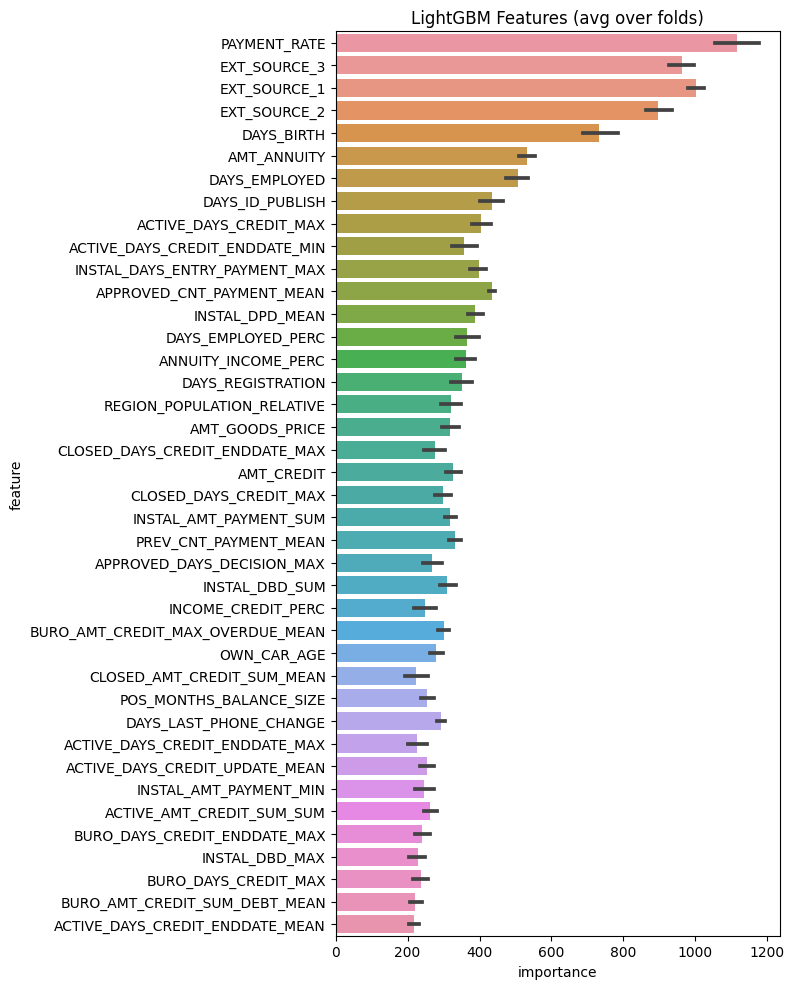

In [ ]:
mlflow.set_experiment("Essai1")
mlflow.lightgbm.autolog()

with mlflow.start_run(run_name="Essai avec L_gbm au lieu de sklearn"):
    if __name__ == "__main__":
        submission_file_name = "submission_kernel02.csv"
        with timer("Full model run"):
            main()

In [1]:
# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2QFBlmmMt5dvPovmisYVrBdpm4P_89dscYx3NmVs7s44og1ng" 
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

NameError: ignored

In [ ]:
!mlflow ui

/bin/bash: mlflow: command not found
